Epoch 1/50
21/21 [==============================] - 3s 20ms/step - loss: 0.5876 - accuracy: 0.0240
Epoch 2/50
21/21 [==============================] - 0s 19ms/step - loss: 0.3298 - accuracy: 0.0285
Epoch 3/50
21/21 [==============================] - 0s 21ms/step - loss: 0.3500 - accuracy: 0.0345
Epoch 4/50
21/21 [==============================] - 0s 21ms/step - loss: 0.2793 - accuracy: 0.0240
Epoch 5/50
21/21 [==============================] - 0s 20ms/step - loss: 0.2609 - accuracy: 0.0390
Epoch 6/50
21/21 [==============================] - 0s 20ms/step - loss: 0.2362 - accuracy: 0.0450
Epoch 7/50
21/21 [==============================] - 0s 20ms/step - loss: 0.2051 - accuracy: 0.0390
Epoch 8/50
21/21 [==============================] - 0s 22ms/step - loss: 0.2052 - accuracy: 0.0450
Epoch 9/50
21/21 [==============================] - 0s 20ms/step - loss: 0.1593 - accuracy: 0.0420
Epoch 10/50
21/21 [==============================] - 0s 20ms/step - loss: 0.1532 - accuracy: 0.0390
Epoch 11/

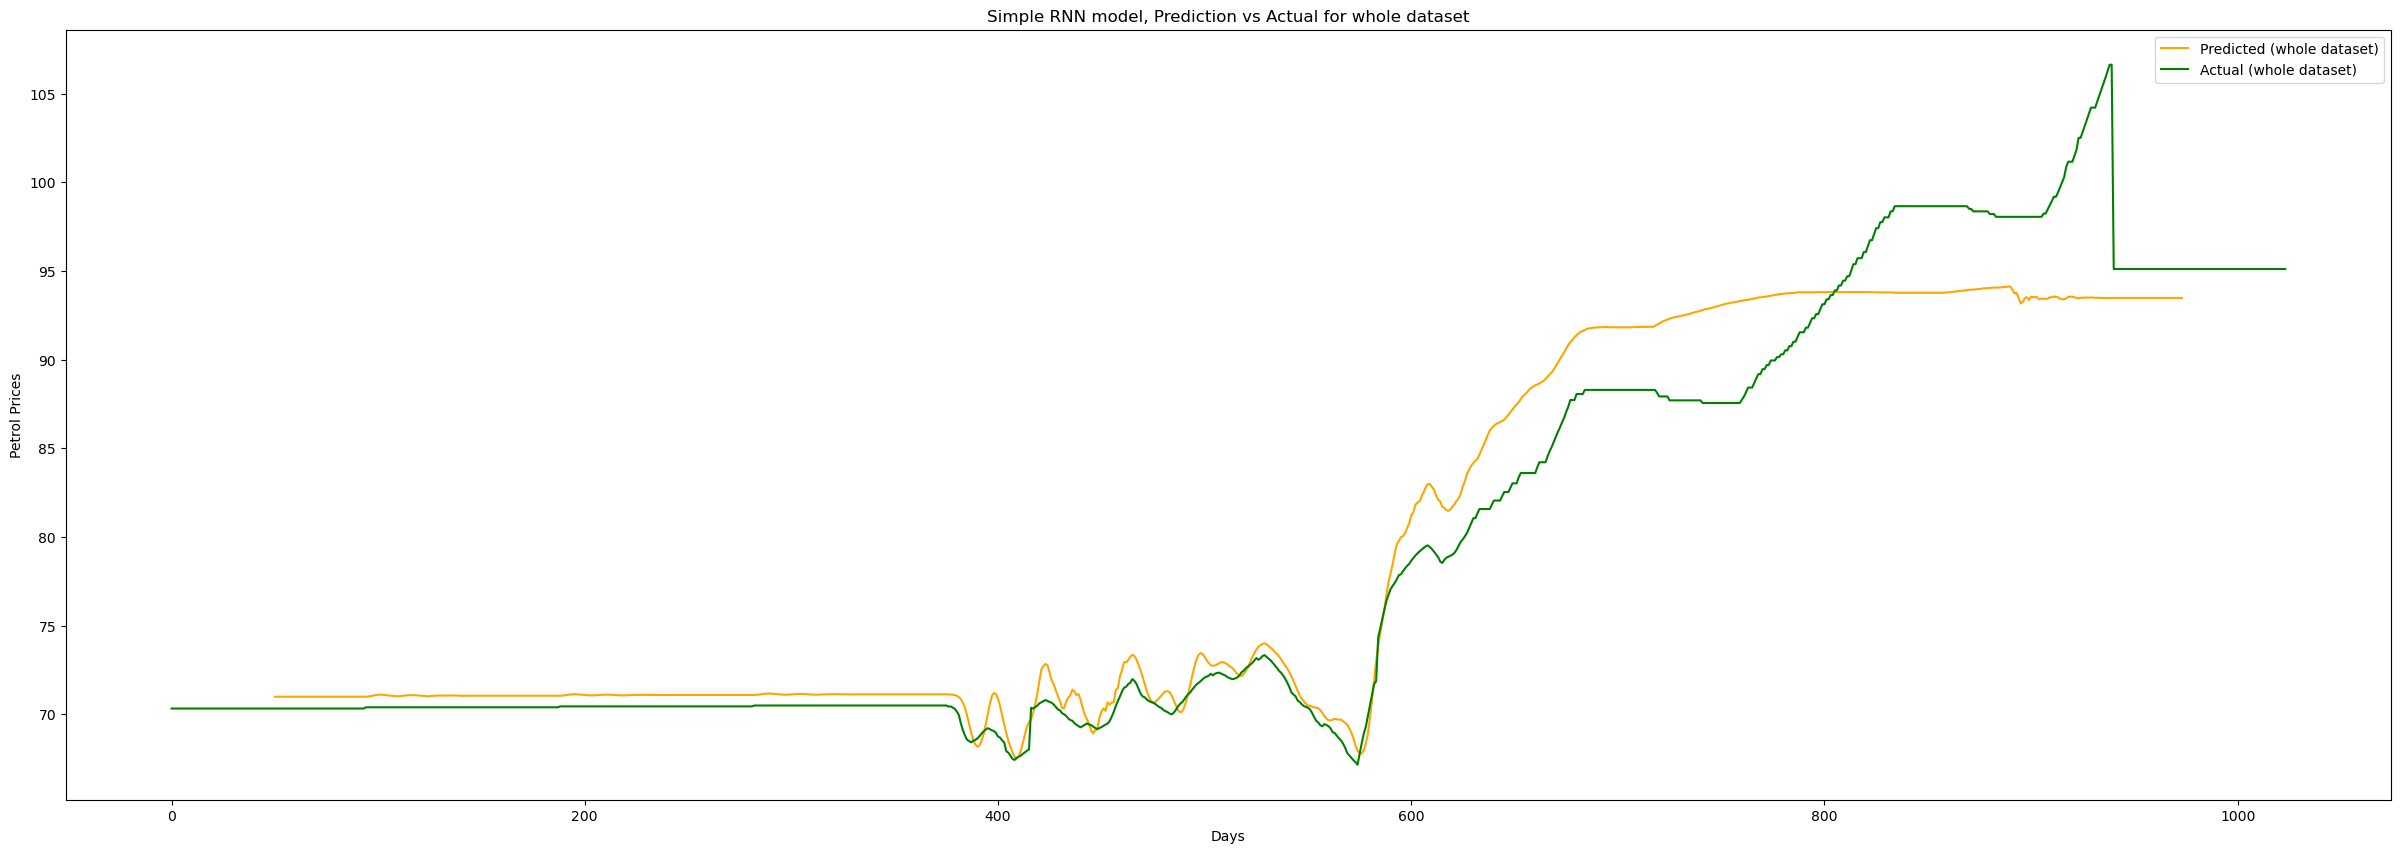

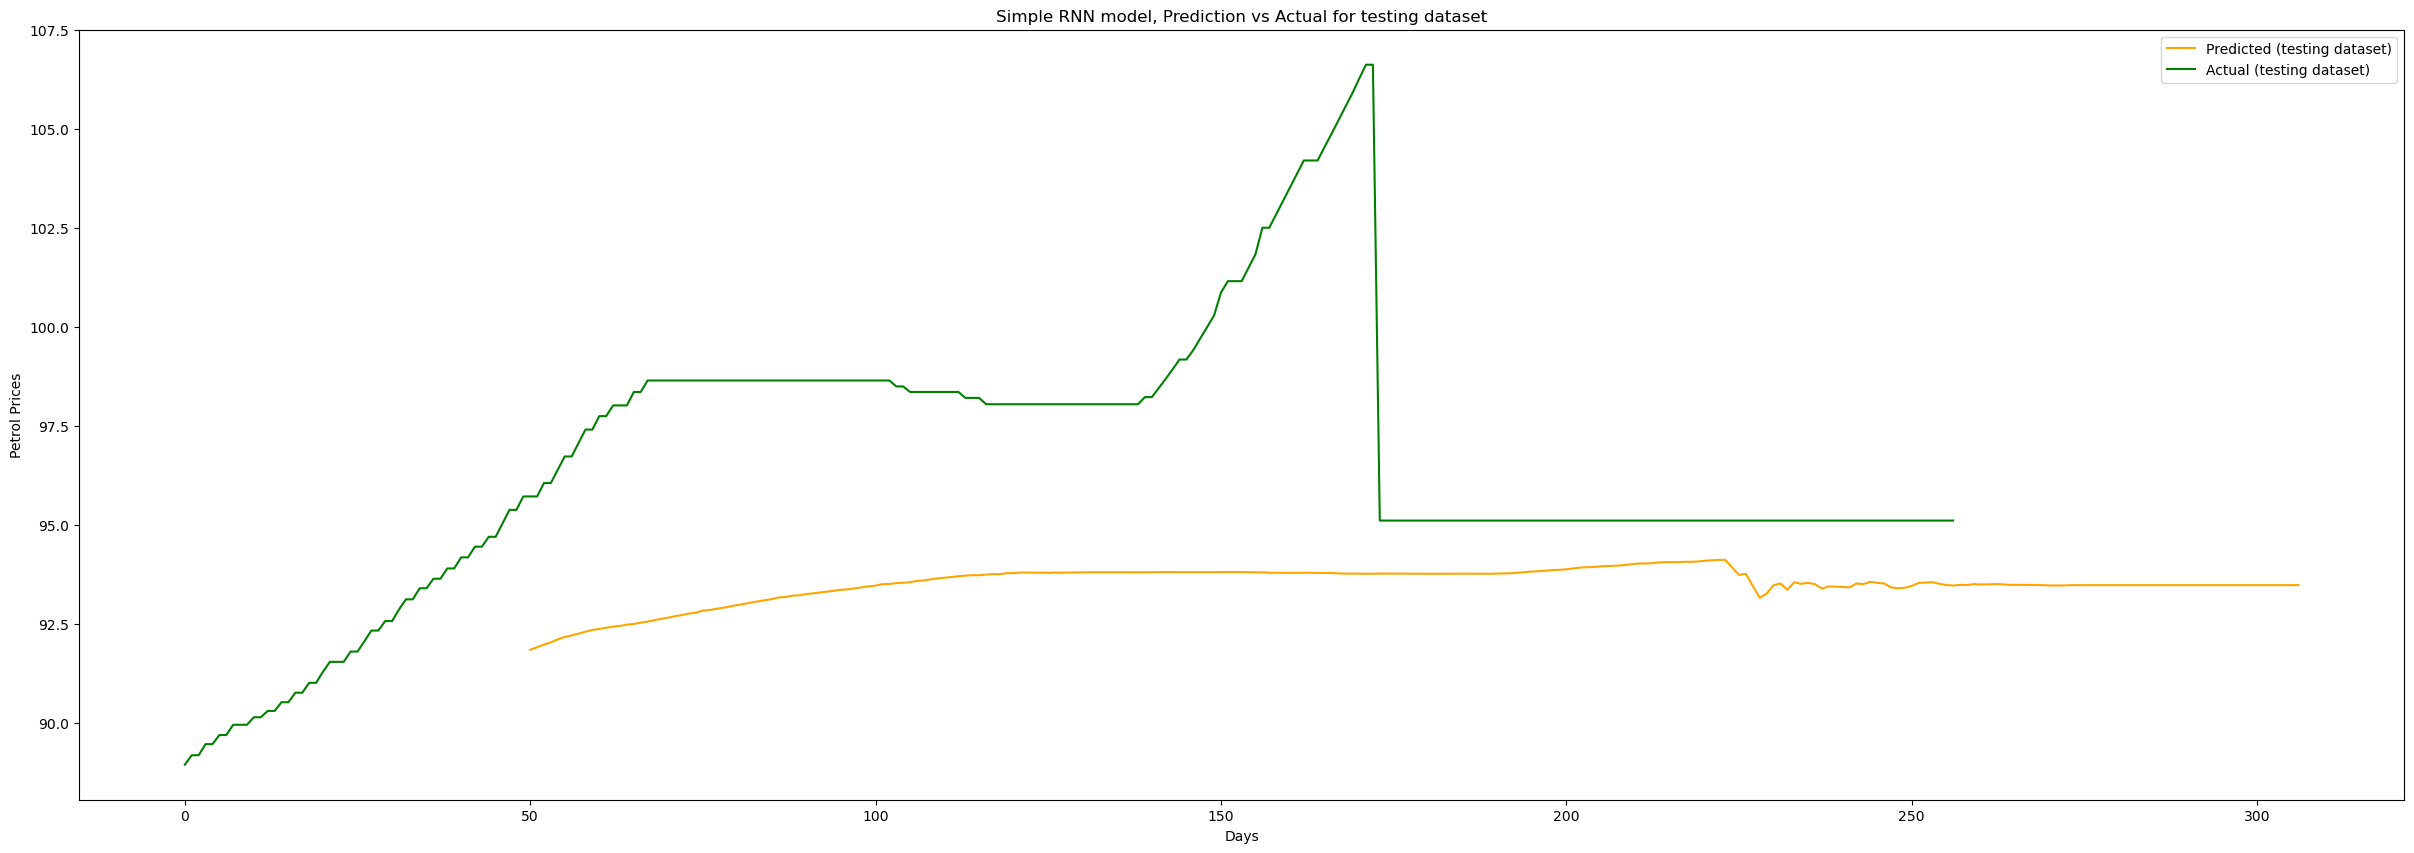

Mean: 79.44580371093774
Correlation between Actual and Predicted Values: 0.884329973577545
21/21 [==============================] - 0s 6ms/step
RMSE on Training Set: 0.0808796391052904
RMSE on Test Set: 4.2553035481487225
21/21 [==============================] - 0s 7ms/step
R2 Score on Training Set: 0.9033094004909449
R2 Score on Test Set: -0.5638626328661132


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error, r2_score

# Load data
data = pd.read_csv("Ahmedabad.csv")

# Check for NaN or infinite values in the data and handle them
if data['rate'].isnull().values.any():
    data['rate'] = data['rate'].fillna(method='ffill')

# Split dataset
length_train = round(len(data) * 0.7)
train_data = data[:length_train]['rate'] 
validation_data = data[length_train:]['rate']

# Normalize
scaler = MinMaxScaler(feature_range = (0,1))
dataset_train_scaled = scaler.fit_transform(train_data.values.reshape(-1,1))

# Create X_train and y_train
time_step = 50
X_train = np.array([dataset_train_scaled[i-time_step:i,0] for i in range(time_step, length_train)])
y_train = np.array([dataset_train_scaled[i,0] for i in range(time_step, length_train)])

# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

# Create RNN model
regressor = Sequential()
regressor.add(SimpleRNN(units = 50,activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

# Compile and fit RNN
regressor.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["accuracy"])
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

# Predictions
y_pred = scaler.inverse_transform(regressor.predict(X_train))

# Validation data
scaled_dataset_validation =  scaler.transform(validation_data.values.reshape(-1,1))

# Create X_test and y_test
X_test = np.array([scaled_dataset_validation[i-time_step:i,0] for i in range(time_step, len(scaled_dataset_validation))])
y_test = np.array([scaled_dataset_validation[i,0] for i in range(time_step, len(scaled_dataset_validation))])

# Reshape
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Predictions with X_test data
y_pred_of_test = scaler.inverse_transform(regressor.predict(X_test))

# Visualisation
plt.figure(figsize = (30,10))
plt.plot(np.concatenate([np.full((time_step,), np.nan), y_pred.flatten(), y_pred_of_test.flatten()]), label = "Predicted (whole dataset)", c = "orange")
plt.plot(data['rate'].values, label = "Actual (whole dataset)", c = "g")
plt.xlabel("Days")
plt.ylabel("Petrol Prices")
plt.title("Simple RNN model, Prediction vs Actual for whole dataset")
plt.legend()
plt.show()

plt.figure(figsize = (30,10))
plt.plot(np.concatenate([np.full((time_step,), np.nan), y_pred_of_test.flatten()]), label = "Predicted (testing dataset)", c = "orange")
plt.plot(data['rate'].values[-len(y_pred_of_test):], label = "Actual (testing dataset)", c = "g")
plt.xlabel("Days")
plt.ylabel("Petrol Prices")
plt.title("Simple RNN model, Prediction vs Actual for testing dataset")
plt.legend()
plt.show()

# Calculate the mean of the 'rate' column
mean_rate = data['rate'].mean()
print(f"Mean: {mean_rate}")

# Calculate the correlation between the actual and predicted values
correlation = np.corrcoef(data['rate'].values[-len(y_pred_of_test):], y_pred_of_test[:, 0])[0, 1]
print(f"Correlation between Actual and Predicted Values: {correlation}")

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, regressor.predict(X_train)))
rmse_test = np.sqrt(mean_squared_error(data['rate'].values[-len(y_pred_of_test):], y_pred_of_test))

print(f"RMSE on Training Set: {rmse_train}")
print(f"RMSE on Test Set: {rmse_test}")

# Calculate R2 Score
r2_train = r2_score(y_train, regressor.predict(X_train))
r2_test = r2_score(data['rate'].values[-len(y_pred_of_test):], y_pred_of_test)

print(f"R2 Score on Training Set: {r2_train}")
print(f"R2 Score on Test Set: {r2_test}")


C:\Users\ASUS\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


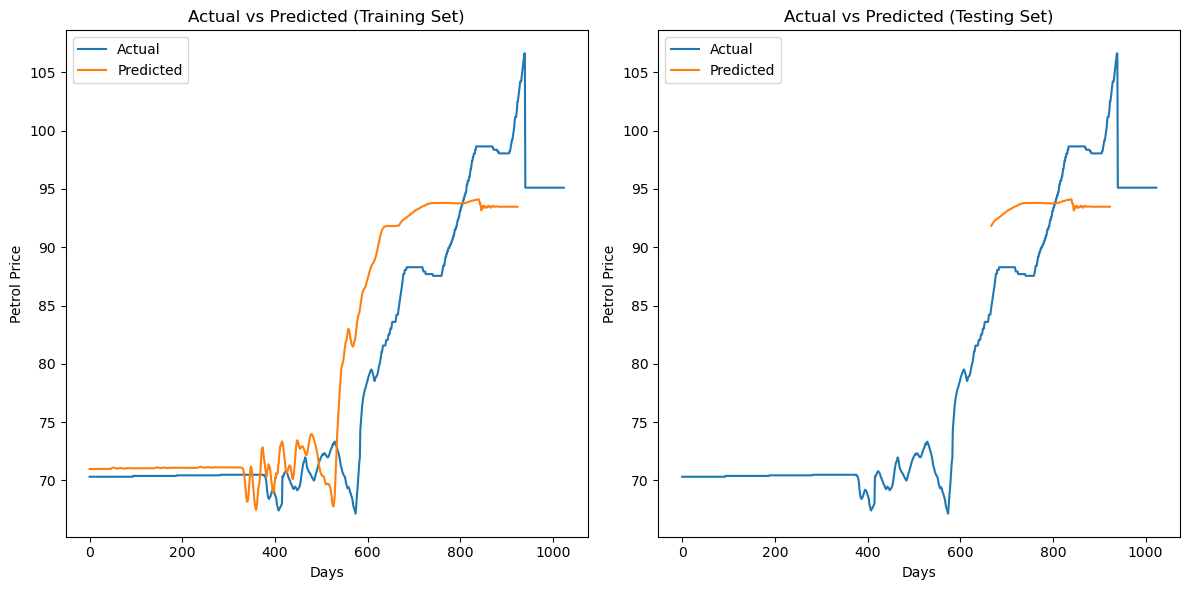

In [3]:

# Plotting the actual vs predicted values for training set
# Plotting the actual vs predicted values for training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(data['rate'], label='Actual')
plt.plot(np.concatenate([y_pred,y_pred_of_test]), label='Predicted')
plt.title('Actual vs Predicted (Training Set)')
plt.xlabel('Days')
plt.ylabel('Petrol Price')
plt.legend(loc='upper left')
# Plotting the actual vs predicted values for testing set
plt.subplot(1, 2, 2)
plt.plot(data['rate'], label='Actual')
plt.plot([None for _ in y_pred] + [x for x in y_pred_of_test], label='Predicted')
plt.title('Actual vs Predicted (Testing Set)')
plt.xlabel('Days')
plt.ylabel('Petrol Price')

plt.legend(loc='upper left')  # This will add the legend to your plots
plt.tight_layout()
plt.show()